In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

# The MNIST Data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


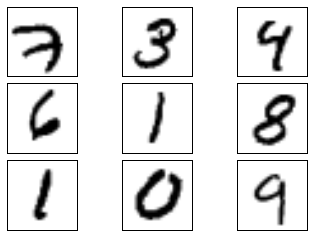

In [3]:
# Plot the first nine MNIST numbers
#
gridspec_kw = {'hspace':0.1, 'wspace':0.1}
subplot_kw = {'xticks':[], 'yticks':[]}
fig, ax = plt.subplots(3, 3, subplot_kw=subplot_kw,
                       gridspec_kw=gridspec_kw)

for i in range(9):
    im = mnist.train.images[i]
    im = im.reshape(28,28)
    
    q,r = i//3, i%3
    axes = ax[q][r]
    
    axes.imshow(im, cmap=plt.cm.gray_r)
    axes.set_aspect('equal')

# Softmax Regression

Let $x$ be the image, $W$ the weights, and $b_i$ the bias. Assume our predicted probabilities $y$ is given by

$$y = \text{softmax(Wx + b)}$$

That is $y_1=1, y_i=0 \; \forall i>1$ means "the image represents the number zero with probability 1".

In [4]:
mnist.train.images.shape

(55000, 784)

In [5]:
x = tf.placeholder(tf.float32, [None, 784]) # N x 784 tensor
W = tf.Variable(tf.zeros([784,10])) # weight matrix (col i modifies image i)
b = tf.Variable(tf.zeros([10])) # bias - one for each class

# nn = activation function module for neural networks
y = tf.nn.softmax(tf.matmul(x,W) + b)

# Training

Define the error function. Use cross-entropy: given predicted distribution $y$ and true distribution $y'$ (i.e. $y'$ are the hot-max vectors)

$$H_y'(y) = -\sum_i y'_i \log(y_i)$$

In [6]:
mnist.train.labels.shape

(55000, 10)

In [7]:
# hot-max labels. sums occur across second dimension (each col)
# represents a label
#
y_ = tf.placeholder(tf.float32, [None, 10])
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

In [42]:
# train: use good old gradient descent to minimize the cross entropy
#
#train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

In [50]:
# initialize session
#
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

# run the training step 1000 times
#

# Method 1) Do it for all of the data at once.
#   * Pros: more accurate
#   * Cons: takes a long time  (55000-dimensional grad desc)

#xs = mnist.train.images
#ys = mnist.train.labels
#for i in range(1000):
#    sess.run(train_step, feed_dict={x:xs, y_:ys})

# Method 2) At each step use a random subset of data points.
#   * Pros: faster
#   * Cons: 

for i in range(10000):
    batch_xs, batch_ys = mnist.train.next_batch(200)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

# Obeservations: 
#   * Method 1 takes a really long time but, in this case, only
#     gets you about an additional 0.5% accuracy

# Evaluate Model

In [51]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9197


# Expert Mode - Multi-Layer Convolutional Network

Step 1. Repeat above.

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
# "placeholder" = placeholder for input data
#
# x = N x 784 images matrix where N = number of images
# y_ = N x 10 one-hot classification matrix
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [3]:
# define weights and biases (parameters to optimize)
#
#    y   =       x.W        +   b
# (Nx10) = (Nx784).(784x10) + (Nx10)
#
# * apply softmax to normalize entries in x.W + b such that
#   each entry represents a probability (normalized exponentials)
#
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))

y = tf.nn.softmax(tf.matmul(x,W) + b)

In [4]:
# cross-entropy = loss function
#
# * cross-entropy of probability distributions, p and q, is
#   a measurement of how similar these distributions are
# * c-e = XXX means completely dissimilar
# * c-e = XXX means completely similar
# * there is a nice min-num bits for cross communications
#   interpretation of cross-entropy
#
# finally, reduction occurs over each column since each row
# represents a distinct image
#
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

In [5]:
# create a "session"
#
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

# training function: minimize c-e using gradient descent
#
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

# stochastic training (for efficiency)
#
for i in range(1000):
    batch = mnist.train.next_batch(100)
    sess.run(train_step, feed_dict={x: batch[0], y_: batch[1]})

In [6]:
# evaluate: just look at largest magnitude entry in y, our
# prediction, and compare to corresponding actual label y_
#
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print(sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9188


### Aside: Plotting the computed weights

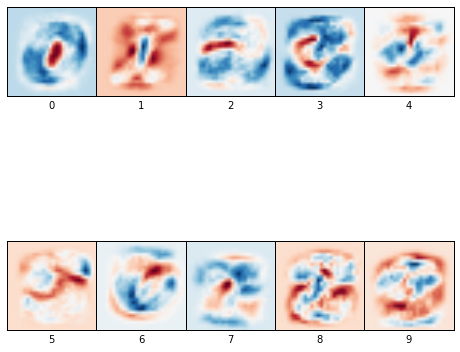

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt

# get the W values
#
Wvalues = W.eval(session=sess)

gridspec_kw = {'hspace':0.1, 'wspace':0.0}
subplot_kw = {'xticks':[], 'yticks':[]}
fig, ax = plt.subplots(2, 5, subplot_kw=subplot_kw,
                       gridspec_kw=gridspec_kw,
                       figsize=(8,8),
                      )

for i in range(10):
    im = Wvalues[:,i]
    im = im.reshape(28,28)
    
    q,r = i//5, i%5
    axes = ax[q][r]
    
    axes.imshow(im, cmap=plt.cm.RdBu)
    axes.set_xlabel(str(i))
    axes.set_aspect('equal')

## Step 2 - Multilayer Convolutional Network

### Initialize Weights

Initialize all weights with a small amount of noise.
* Break symmetry
* Positive (we're using ReLu neurons)

In [42]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

### Convolution and Pooling

Why convolve?
* "shift-invariant" - convolving data makes the structure position independent (e.g. a "4" is a "4" no matter where it's located in the image)
* "time-invariant" - temporal version of above
* more?

Convolutional Layer
* [sort of understand why you would do it based on above and how convolutions are used elsewhere]
* Rarely globally connected - too much work and sometimes you want to capture locality
* Parameters:
  * depth
  * stride
  * zero-padding
  
Pooling Layer
* Down-sampling the convolution output
* example: max pooling (partition output and take max in each partition) idea is that once a "feature" has been found its exact location isn't as important as its rough location relative to other features identified in other partitions
* others: L1-norm, L2-norm

In [43]:
# convolution: stride of one and are zero padded
#
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1],
                        padding='SAME')

# pooling: max pool over 2x2 blocks
#
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1],
                          padding='SAME')

### First Layer

Convolution + max pooling. Convolution will compute 32 features for each 5x5 patch. Weight tensor = `[5, 5, 1, 32]`.
* `5, 5` - dimensions of patch size
* `1` - number of input channels
* `32` - number of output channels

To apply the layer, reshape `x` to a 4d tensor: first dimension is ?, next two are width and height, and final dimension is number of color channels.

Then, convolve the reshaped image with the weight tensor, apply the ReLU function, and finally max pool.

In [45]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, [-1,28,28,1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

### Second Layer

Adding depth to the layer: 64 features for each 5x5 patch.

In [46]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

### Densely Connected Layer

The images are reduced to 7x7 data. Add a fully-connected layer with 1024 neurons to process the entire image. The tensor from the pooling layer is reshaped into a batch of vectors which is then multiplied by a weight matrix and summed with a bias. Then ReLU is applied.

In [47]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

### Dropout

To reduce overfitting. Idea: randomly drop units and their corresp. connections from the neural network during training. Then, average out the results. Better than other regularization methods. (minimizing L1 norms)

In [48]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

### Readout Layer

Finally, softmax for final classification.

In [49]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

## Training

* Use ADAM instead of gradient descent.
* Include `keep_prob` parameter in `feed_dict` to control dropout rate.
* Include logging on each 100 iterations.

In [55]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.initialize_all_variables())

## iterate
#
for i in range(5000):
    batch = mnist.train.next_batch(50)
    if i%100 == 0:
        train_accuracy = accuracy.eval(session=sess, feed_dict={
            x:batch[0], y_: batch[1], keep_prob: 1.0})
        print("step %d, training accuracy %g"%(i, train_accuracy))
    sess.run(train_step, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(session=sess, feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

step 0, training accuracy 0.06
step 100, training accuracy 0.86
step 200, training accuracy 0.9
step 300, training accuracy 0.98
step 400, training accuracy 0.9
step 500, training accuracy 0.96
step 600, training accuracy 0.86
step 700, training accuracy 1
step 800, training accuracy 0.98
step 900, training accuracy 0.96
step 1000, training accuracy 0.96
step 1100, training accuracy 0.98
step 1200, training accuracy 0.98
step 1300, training accuracy 0.96
step 1400, training accuracy 0.94
step 1500, training accuracy 0.98
step 1600, training accuracy 0.98
step 1700, training accuracy 0.96
step 1800, training accuracy 0.94
step 1900, training accuracy 1
step 2000, training accuracy 0.98
step 2100, training accuracy 0.98
step 2200, training accuracy 0.98
step 2300, training accuracy 0.98
step 2400, training accuracy 1
step 2500, training accuracy 0.94
step 2600, training accuracy 0.98
step 2700, training accuracy 0.96
step 2800, training accuracy 1
step 2900, training accuracy 0.98
step 3

In [57]:
from pylab import genfromtxt

csv_test = genfromtxt('/Users/cswiercz/Downloads/test.csv',
                      delimiter=',',
                      skip_header=1)

In [67]:
guess_digit = tf.argmax(y_conv,1)
csv_test_scale = csv_test / 255.

In [68]:
calculated_guess = guess_digit.eval(
    session=sess, feed_dict={
        x: csv_test_scale,
        keep_prob: 1.0}
)

In [69]:
# double-check accuracy from training data
#
print("test accuracy %g"%accuracy.eval(session=sess, feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

test accuracy 0.9853


In [70]:
calculated_guess

array([2, 0, 9, ..., 3, 9, 2])

In [81]:
indices = np.arange(len(calculated_guess)) + 1
table = np.vstack([indices, calculated_guess]).T

table

array([[    1,     2],
       [    2,     0],
       [    3,     9],
       ..., 
       [27998,     3],
       [27999,     9],
       [28000,     2]])

In [83]:
np.savetxt('/Users/cswiercz/Desktop/cnn.csv', table,
           delimiter=',', header='ImageId,Label', fmt='%d,%d')

# Plotting Layers

In [88]:
W_conv1_values = W_conv1.eval(session=sess)

In [89]:
W_conv1_values.shape

(5, 5, 1, 32)

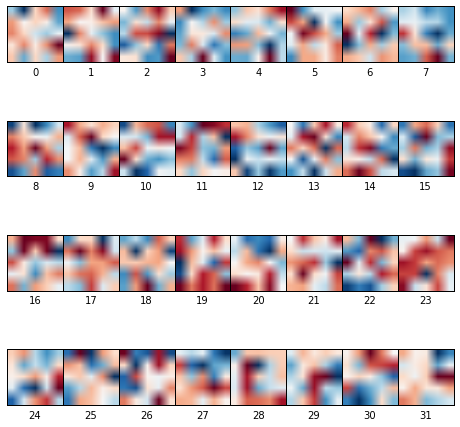

In [96]:
%matplotlib inline
import matplotlib.pyplot as plt

# get the W values
#
Wvalues = W_conv1_values

gridspec_kw = {'hspace':0.1, 'wspace':0.0}
subplot_kw = {'xticks':[], 'yticks':[]}
fig, ax = plt.subplots(4, 8, subplot_kw=subplot_kw,
                       gridspec_kw=gridspec_kw,
                       figsize=(8,8),
                      )

for i in range(32):
    im = Wvalues[:,:,0,i]
    
    q,r = i//8, i%8
    axes = ax[q][r]
    
    axes.imshow(im, cmap=plt.cm.RdBu)
    axes.set_xlabel(str(i))
    axes.set_aspect('equal')

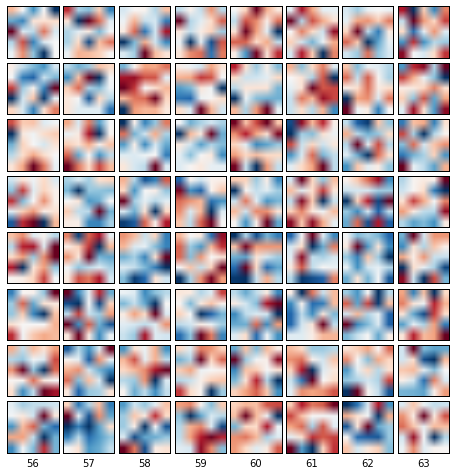

In [102]:
%matplotlib inline
import matplotlib.pyplot as plt

# get the W values
#
Wvalues = W_conv2.eval(session=sess)

gridspec_kw = {'hspace':0.1, 'wspace':0.0}
subplot_kw = {'xticks':[], 'yticks':[]}
fig, ax = plt.subplots(8, 8, subplot_kw=subplot_kw,
                       gridspec_kw=gridspec_kw,
                       figsize=(8,8),
                      )

for i in range(64):
    #im = Wvalues[:,:,0,i]
    im = np.average(Wvalues[:,:,:,i], axis=2)
    
    q,r = i//8, i%8
    axes = ax[q][r]
    
    axes.imshow(im, cmap=plt.cm.RdBu)
    axes.set_xlabel(str(i))
    axes.set_aspect('equal')

In [101]:
np.average?